In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.95' # NOTE: jax preallocates GPU (default 75%)
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree, lax, value_and_grad
jconfig.update("jax_enable_x64", True)
print(jdevices())

# from montecosmo.model import FieldLevelModel, default_config
# from montecosmo.utils import pdump, pload , Path
from pathlib import Path

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname
#!jupyter nbconvert --to python /dvs_ro/u1/h/hsimfroy/workspace/montecosmo_proj/src/montecosmo/tests/infer_model2.ipynb

save_dir = Path("./scratch")
# save_dir = Path("/feynman/home/dphp/hs276503/scratch/png/kaiser_test21")
# save_dir = Path("/pscratch/sd/h/hsimfroy/png/kaiser_test21")
save_path = save_dir / "test"
save_dir.mkdir(parents=True, exist_ok=True)

[cuda(id=0)]
feynmangpu04.cluster.local


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Import

In [2]:
import glob
cosmo, ic, tracer, meshsize, resampler, z = 0, 0, 'LRG', 576, 'ngp', 0.8

fn = {}
outdir = Path(os.getenv('SCRATCH')) / f'bias/{tracer}/z{z:.3f}/AbacusSummit_base_c{cosmo:03d}_ph{ic:03d}/'
fn['catalog_tracer'] = f'/dvs_ro/cfs/cdirs/desi/cosmosim/SecondGenMocks/CubicBox/{tracer}/z{z:.3f}/AbacusSummit_base_c{cosmo:03d}_ph{ic:03d}/LRG_real_space.fits'
fn['mesh_ic'] = f'/dvs_ro/cfs/cdirs/desi/public/cosmosim/AbacusSummit/ic/AbacusSummit_base_c{cosmo:03d}_ph{ic:03d}/ic_dens_N576.asdf'
fns = [glob.glob(f'/dvs_ro/cfs/cdirs/desi/public/cosmosim/AbacusSummit/AbacusSummit_base_c{cosmo:03d}_ph{ic:03d}/halos/z{z:.3f}/{t}_rv_A/{t}_rv_A_*.asdf') for t in ['field', 'halo']]
fn['catalog_particle'] = sorted(sum(fns, []))
fns = fn

In [ ]:
# IC
def read_mesh(fn, z=None):
    fn = str(fn)
    import asdf
    with asdf.open(fn) as af:
        growth_table = 1.
        if z is not None:
            growth_table = af['header']['GrowthTable'][z]
        toret = jnp.array(af['data']['density']) * growth_table
    return toret
init_mesh = read_mesh(fns['mesh_ic'], z=0)
mesh_shape = init_mesh.shape
print(mesh_shape)
jnp.save(save_dir / 'init_mesh.npy', init_mesh)

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250331-1.0.0/conda/lib/python3.10/site-packages/asdf/yamlutil.py:355: AsdfConversionWarning: tag:stsci.edu:asdf/core/column-1.0.0 is not recognized, converting to raw Python data structure
  warnings.warn(
/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250331-1.0.0/conda/lib/python3.10/site-packages/asdf/yamlutil.py:355: AsdfConversionWarning: tag:astropy.org:astropy/table/table-1.0.0 is not recognized, converting to raw Python data structure
  warnings.warn(
/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250331-1.0.0/conda/lib/python3.10/site-packages/asdf/_asdf.py:294: AsdfPackageVersionWarning: File 'file:///dvs_ro/cfs/cdirs/desi/public/cosmosim/AbacusSummit/ic/AbacusSummit_base_c000_ph000/ic_dens_N576.asdf' was created with extension URI 'asdf://astropy.org/astropy/extensions/astropy-1.0.0' (from package asdf-astropy==0.2.2), which is not currently installed
  w

(576, 576, 576)


In [3]:
from itertools import product

paint_kernels = [
    lambda s: jnp.full(jnp.shape(s)[-1:], jnp.inf), # Dirac
    lambda s: jnp.full(jnp.shape(s)[-1:], 1.), # NGP
    lambda s: 1 - s, # CIC
    lambda s: (s <= 1/2) * (3/4 - s**2) + (1/2 < s) / 2 * (3/2 - s)**2, # TSC
    lambda s: (s <= 1) / 6 * (4 - 6 * s**2 + 3 * s**3) + (1 < s) / 6 * (2 - s)**3, # PCS
]

def paint(pos, mesh:tuple|jnp.ndarray, weights=1., order:int=2):
    """
    Paint the positions onto the mesh. 
    If mesh is a tuple, paint on a zero mesh with such shape.
    """
    if isinstance(mesh, tuple):
        mesh = jnp.zeros(mesh)
    else:
        mesh = jnp.asarray(mesh)

    dtype = 'int16' # int16 -> +/- 32_767, trkl
    shape = np.asarray(mesh.shape, dtype=dtype)
    def wrap(idx):
        return idx % shape
    
    id0 = (jnp.round if order % 2 else jnp.floor)(pos).astype(dtype)
    ishifts = np.arange(order) - (order - 1) // 2
    ishifts = np.array(list(product(* len(shape) * (ishifts,))), dtype=dtype)

    def step(carry, ishift):
        idx = id0 + ishift
        s = jnp.abs(idx - pos)
        idx, ker = wrap(idx), paint_kernels[order](s).prod(-1)

        # idx = jnp.unstack(idx, axis=-1)
        idx = tuple(jnp.moveaxis(idx, -1, 0)) # TODO: JAX >= 0.4.28 for unstack
        carry = carry.at[idx].add(weights * ker)
        return carry, None
    
    mesh = lax.scan(step, mesh, ishifts)[0]
    return mesh


def read(pos, mesh:jnp.ndarray, order:int=2):
    """
    Read the value at the positions from the mesh.
    """
    dtype = 'int16' # int16 -> +/- 32_767, trkl
    shape = np.asarray(mesh.shape, dtype=dtype)
    def wrap(idx):
        return idx % shape
    
    id0 = (jnp.round if order % 2 else jnp.floor)(pos).astype(dtype)
    ishifts = np.arange(order) - (order - 1) // 2
    ishifts = np.array(list(product(* len(shape) * (ishifts,))), dtype=dtype)

    def step(carry, ishift):
        idx = id0 + ishift
        s = jnp.abs(idx - pos)
        idx, ker = wrap(idx), paint_kernels[order](s).prod(-1)

        # idx = jnp.unstack(idx, axis=-1)
        idx = tuple(jnp.moveaxis(idx, -1, 0)) # TODO: JAX >= 0.4.28 for unstack
        carry += mesh[idx] * ker
        return carry, None
    
    out = jnp.zeros(id0.shape[:-1])
    out = lax.scan(step, out, ishifts)[0]
    return out

In [ ]:
# Particle
from abacusnbody.data import read_abacus
from tqdm import tqdm
paint_order = 2
n_mesh = 576
mesh_shape = 3*(n_mesh,)
pos_min, pos_max = -1000., 1000.
init_paint = jnp.zeros(mesh_shape)
fin_paint = jnp.zeros(mesh_shape)

for fn in tqdm(fns['catalog_particle']):
    init_pos = read_abacus.read_asdf(fn.replace('_rv', '_pid'), load=['lagr_pos'])['lagr_pos']
    init_pos = (init_pos - pos_min) / (pos_max - pos_min) * n_mesh
    init_paint += paint(init_pos, init_paint, order=paint_order)

    fin_pos = read_abacus.read_asdf(fn, load=['pos'])['pos']
    fin_pos = (fin_pos - pos_min) / (pos_max - pos_min) * n_mesh
    fin_paint += paint(fin_pos, fin_paint, order=paint_order)

jnp.save(save_dir / "init_paint.npy", init_paint)
jnp.save(save_dir / "fin_paint.npy", fin_paint)

In [ ]:
# Tracer
import fitsio
paint_order = 2
n_mesh = 576
positions = fitsio.read(fns['catalog_tracer'])
positions = np.column_stack([positions[name] for name in ['x', 'y', 'z']])
print(len(positions), positions.min(), positions.max())
positions = (positions - positions.min()) / (positions.max() - positions.min()) * n_mesh
print(positions.min(), positions.max())
tracer_mesh = paint(positions, 3*(n_mesh,), order=paint_order)
tracer_mesh *= np.prod(tracer_mesh.shape) / len(positions)
print(tracer_mesh.mean())
np.save(save_dir / f'tracer_mesh_{len(positions)}.npy', tracer_mesh)

6746545 -1000.0 1000.0
0.0 576.0
0.9999999999999999


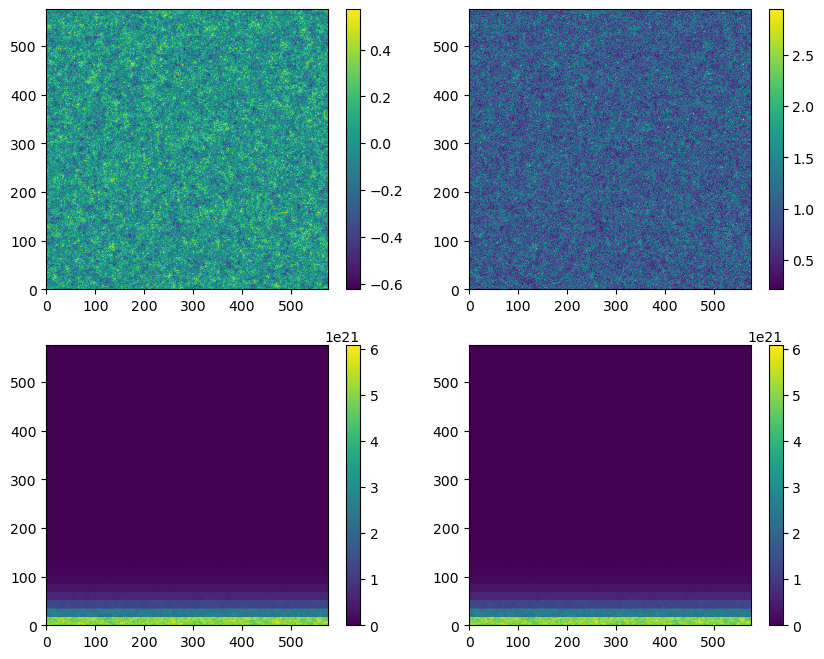

In [11]:
init_mesh0 = jnp.load("./scratch/init_mesh.npy")
tracer_mesh0 = jnp.load("./scratch/tracer_mesh.npy")
init_paint = jnp.load("./scratch/init_paint.npy")
fin_paint = jnp.load("./scratch/fin_paint.npy")
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.pcolormesh(init_mesh0.mean(2))
plt.colorbar()
plt.subplot(222)
plt.pcolormesh(tracer_mesh0.mean(2))
plt.colorbar()
plt.subplot(223)
plt.pcolormesh(fin_paint.mean(2))
plt.colorbar()
plt.subplot(224)
plt.pcolormesh(fin_paint.mean(2))
plt.colorbar()
plt.show()

In [ ]:
import plotly.express as px
idx = np.random.choice(positions.shape[0], size=10000, replace=False)
pos = positions[idx]

fig = px.scatter_3d(
    x=pos[:, 0],
    y=pos[:, 1],
    z=pos[:, 2],
    title="Random Sample of 10,000 Positions"
)
fig.update_traces(marker=dict(size=2))
fig.show()

In [12]:
from cosmoprimo.fiducial import AbacusSummit

cosmo = AbacusSummit()
pk_interpolator = cosmo.get_fourier().pk_interpolator().to_1d(z=z)
# pk_interpolator(k)
cosmo.Omega0_cdm

0.26447041034523616

## Validation

In [ ]:
# tracer_mesh0 = jnp.load("./scratch/tracer_mesh0_6746545.npy")
# from montecosmo.plot import plot_mesh, plot_pow
# from montecosmo.utils import chreshape, r2chshape
# from montecosmo.metrics import spectrum

# box_shape = 3*(2000,)
# mesh_shape = 3*(128,)
# n_tracers = 6746545

# print('mean: ', tracer_mesh0.mean())
# print('ngbar: ', tracer_mesh0.sum() / np.prod(box_shape))

# tracer_mesh = jnp.fft.rfftn(tracer_mesh0)
# tracer_mesh = chreshape(tracer_mesh, r2chshape(mesh_shape))
# tracer_mesh = jnp.fft.irfftn(tracer_mesh)
# print('mean: ', tracer_mesh.mean())
# tracer_mesh *= n_tracers / tracer_mesh.sum()
# print('ngbar: ', tracer_mesh.sum() / np.prod(box_shape))
# jnp.save("./scratch/tracer_mesh_6746545.npy", tracer_mesh)
tracer_mesh = jnp.load(f"./scratch/tracer_mesh_6746545_{mesh_shape[0]}.npy")

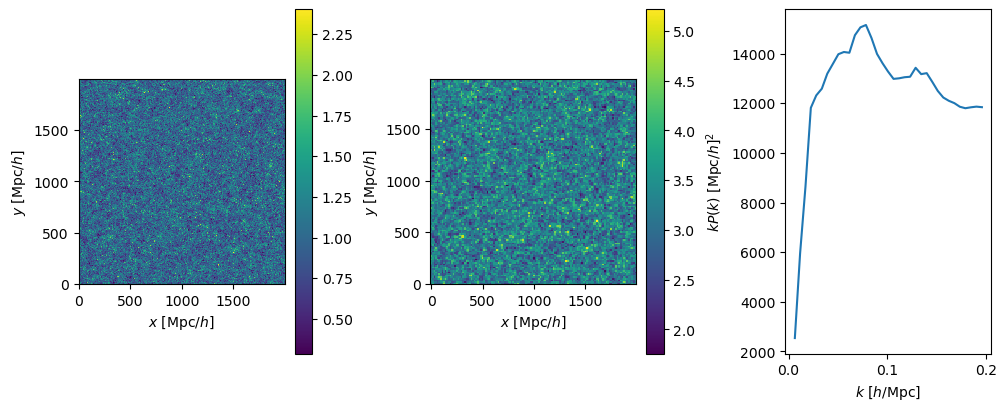

In [16]:
plt.figure(figsize=(10, 4), layout="constrained")
plt.subplot(131)
plot_mesh(tracer_mesh0, box_shape)
plt.colorbar()
plt.subplot(132)
plot_mesh(tracer_mesh, box_shape)
plt.colorbar()
plt.subplot(133)
pow_tracer0 = spectrum(tracer_mesh0, box_shape=box_shape)
pow_tracer = spectrum(tracer_mesh, box_shape=box_shape)
# plot_pow(*pow_tracer0)
plot_pow(*pow_tracer);

# CONFIG
{'a_obs': 1.0,
 'ap_auto': None,
 'box_center': array([0., 0., 0.]),
 'box_rotvec': array([0., 0., 0.]),
 'cell_length': 31.25,
 'curved_sky': False,
 'evolution': 'lpt',
 'init_oversamp': 1.0,
 'interlace_order': 2,
 'k_cut': 0.10053096491487339,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3111,
                         'low': 0.05,
                         'scale': 0.5,
                         'scale_fid': 0.01},
             'alpha_ap': {'group': 'ap',
                          'high': inf,
                          'label': '{\\alpha_\\mathrm{AP}}',
                          'loc': 1.0,
                          'loc_fid': 1.0,
                          'low': 0.0,
                          'scale': 0.1,
                          'scale_fid': 0.01},
             'alpha_iso': {'group': 'ap',
                    

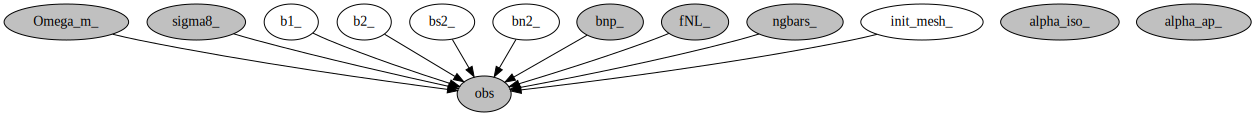

In [6]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload , Path

box_shape = 3*(2000,)
cell_budget = 64**3
selection = None
mesh_length = round(cell_budget**(1/3))

model = FieldLevelModel(**default_config | 
                        {'mesh_shape': 3*(mesh_length,), 
                        'cell_length': box_shape[0] / mesh_length, # in Mpc/h
                        'box_center': (0.,0.,0.), # in Mpc/h
                        'box_rotvec': (0.,0.,0.,), # rotation vector in radians
                        'evolution': 'lpt',
                        'a_obs': 1., # light-cone if None
                        'curved_sky': False, # curved vs. flat sky
                        'ap_auto': None, # parametrized AP vs. auto AP
                        'selection': selection, # if float, padded fraction, if str or Path, path to window mesh file
                        'paint_order':2, # order of interpolation kernel
                        'init_oversamp':1., # initial mesh 1D oversampling factor
                        'ptcl_oversamp':1., # particle grid 1D oversampling factor
                        'paint_oversamp':1., # painted mesh 1D oversampling factor
                        'interlace_order':2, # interlacing order
                        'n_rbins': 1,
                        'k_cut': None,
                        } )

print(model)
# model.render()

truth = {
    'Omega_m': 0.3, 
    # 'Omega_c': 0.3-0.04860,
    # 'Omega_b': 0.04860,
    'sigma8': 0.8,
    'b1': 1.,
    'b2': 0.,
    'bs2': 0.,
    'bn2': 0.,
    'bnp': 0.,
    'fNL': 0.,
    'alpha_iso': 1.,
    'alpha_ap': 1.,
    'ngbars': 0.00084,
    }

truth2 = model.predict(samples=truth, hide_base=False, hide_samp=False, from_base=True)
truth = truth2
# truth = truth | {'obs': tracer_mesh}
model.save(save_dir / "model.yaml")    
jnp.savez(save_dir / "truth.npz", **truth)
delta_obs = model.count2delta(truth['obs'])
# delta_obs2 = model.count2delta(truth2['obs'])
# count_obs  = model.masked2mesh(truth['obs'])
# count_obs2  = model.masked2mesh(truth2['obs'])

obs = ['obs','Omega_m','sigma8','fNL','bnp','alpha_iso','alpha_ap','ngbars']
# obs = ['obs','Omega_m','sigma8','fNL','b1','b2','bs2','bn2','bnp','alpha_iso','alpha_ap','ngbars']
# obs = ['obs','fNL','b1','b2','bs2','bn2','bnp','alpha_iso','alpha_ap','ngbars']
# obs = ['obs','fNL','alpha_iso','alpha_ap']
# obs = ['obs','fNL','bnp','alpha_iso','alpha_ap']
obs = {k: truth[k] for k in obs}

model.condition(obs, from_base=True)
model.block()
# start_params = jit(vmap(partial(model.kaiser_post, delta_obs=delta_obs, scale_field=1/10)))(jr.split(jr.key(45), n_chains)) 
params_start = model.kaiser_post(jr.key(45), delta_obs, scale_field=1/10)
print('start params:', params_start.keys())
model.render()
potential_valgrad = jit(value_and_grad(model.potential))

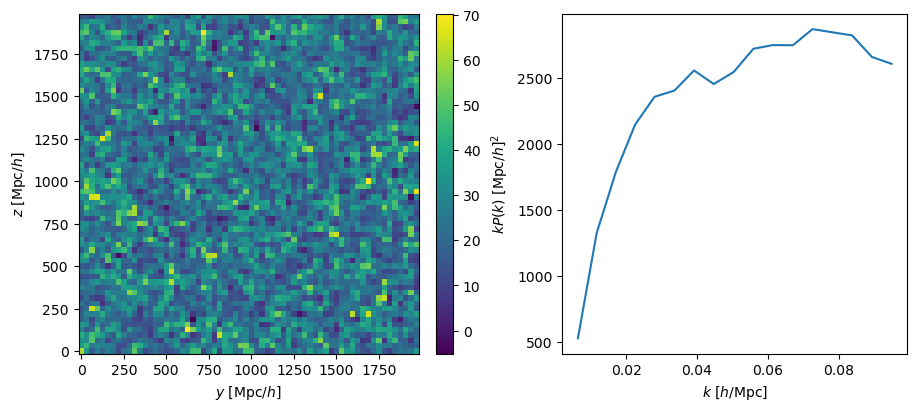

In [5]:
from montecosmo.plot import plot_mesh, plot_pow
axis = 0
ids = .1

plt.figure(figsize=(9, 4), layout="constrained")
plt.subplot(121)
plot_mesh(model.masked2mesh(truth['obs']), box_shape, ids, axis)
plt.colorbar()
plt.subplot(122)
plot_pow(*model.spectrum(delta_obs));
# plot_pow(*model.spectrum(delta_obs2));

In [ ]:
from jax.example_libraries.optimizers import adam
from tqdm import tqdm
lr0 = 1.
n_epochs = 500
energies = []

lr_fn = lambda i: lr0 / (1 + i)**.5
opt_init, opt_update, get_params = adam(lr_fn)
opt_state = opt_init(params_start)
# opt_state = opt_init(params)

def step(step, opt_state):
    value, pot_grad = potential_valgrad(get_params(opt_state))
    opt_state = opt_update(step, pot_grad, opt_state)
    return value, opt_state

for i_epoch in tqdm(range(n_epochs)):
    value, opt_state = step(i_epoch, opt_state)
    energies.append(float(value))
params = get_params(opt_state)
jnp.savez(save_dir / f'params_mode_{model.mesh_shape[0]}.npz', **params)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [01:08<00:00,  7.29it/s]


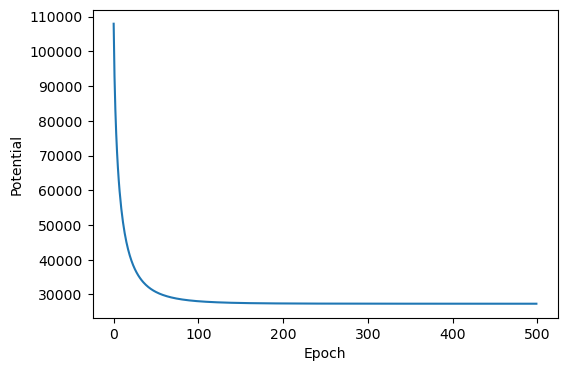

In [5]:
plt.figure(figsize=(6,4))
plt.plot(energies)
plt.xlabel("Epoch"), plt.ylabel("Potential")
plt.show()

Chains(data={'b2': Array(0.18354903, dtype=float64), 'b1': Array(1.2183641, dtype=float64), 'bn2': Array(-22.77584076, dtype=float64), 'bs2': Array(0.01984765, dtype=float64)}, groups={}, labels={})


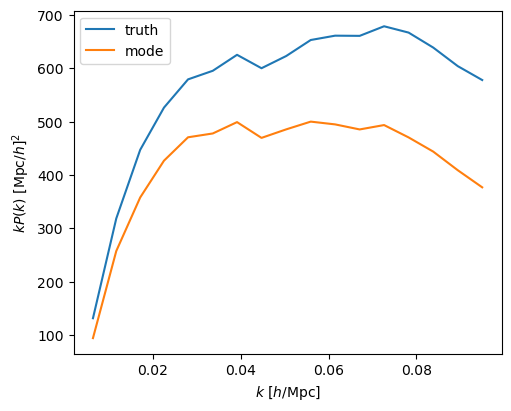

In [4]:
from montecosmo.chains import Chains
params = dict(jnp.load(save_dir / f'params_mode_{model.mesh_shape[0]}.npz'))
post_mode = Chains(model.reparam(params))
theta_mode, init_mode = post_mode[['*~init_mesh'],'init_mesh']
print(theta_mode)
plt.figure(figsize=(5, 4), layout="constrained")
plot_pow(*model.spectrum(truth['init_mesh']), label='truth')
plot_pow(*model.spectrum(init_mode), label='mode')
plt.legend();

In [ ]:
from montecosmo.chains import Chains
from montecosmo.lapprox import cov_x_from_pot_x_y

theta, mesh = Chains(params)[['*~init_mesh_'],['init_mesh_']]
(theta, unravel), (mesh, _) = theta.ravel(0), mesh.ravel(0)
names = list(unravel(theta).keys())
labels = [model.labels[k] for k in names]

def pot_fn(theta, mesh):
    params = unravel(theta) | {"init_mesh_": mesh}
    return model.potential(params.data)

cov_x, schur = cov_x_from_pot_x_y(pot_fn, theta, mesh, method='hutchinson', chunk_size=128)
jnp.save(save_dir / f'cov_mode_{model.mesh_shape[0]}.npy', cov_x)
jnp.save(save_dir / f'schur_mode_{model.mesh_shape[0]}.npy', schur)
print(jnp.linalg.eigvalsh(cov_x))

[-1.11442354e-03  7.03347360e-03  1.42559890e-02  7.91406757e+00]


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/getdist/gaussian_mixtures.py:39: RuntimeWarning: invalid value encountered in sqrt
  self.norms = (2 * np.pi) ** (0.5 * self.dim) * np.array([np.sqrt(np.linalg.det(cov)) for cov in self.covs])


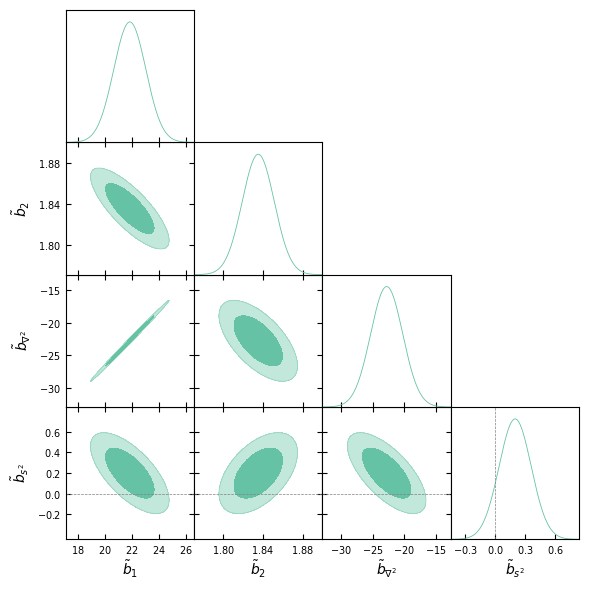

In [77]:
%matplotlib inline
from getdist import plots, gaussian_mixtures
from montecosmo.plot import SetDark2

gd_fisher = gaussian_mixtures.GaussianND(theta, cov_x, names=names, labels=labels, label='Full Lapprox')
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(gd_fisher, 
                filled=True, 
                contour_colors=[SetDark2(0)], 
                markers=truth)

In [ ]:
n_chains = 2
model.reset()
truth2 = model.predict(samples=(2,30), hide_base=True, hide_samp=True, from_base=True)

In [58]:
batch_ndim = 2
theta = Chains(truth2, model.groups_)[['*~init_mesh_','~init_mesh','~obs']]
out, unravel = theta.ravel(1)
print(theta.shape)
print(out.shape)
print(unravel(out).shape)

{'Omega_m_': (2, 30), 'alpha_ap_': (2, 30), 'alpha_iso_': (2, 30), 'b1_': (2, 30), 'b2_': (2, 30), 'bn2_': (2, 30), 'bnp_': (2, 30), 'bs2_': (2, 30), 'fNL_': (2, 30), 'ngbars_': (2, 30, 1), 'sigma8_': (2, 30)}
(2, 330)
{'Omega_m_': (2, 30), 'alpha_ap_': (2, 30), 'alpha_iso_': (2, 30), 'b1_': (2, 30), 'b2_': (2, 30), 'bn2_': (2, 30), 'bnp_': (2, 30), 'bs2_': (2, 30), 'fNL_': (2, 30), 'ngbars_': (2, 30, 1), 'sigma8_': (2, 30)}


Removed no burn in


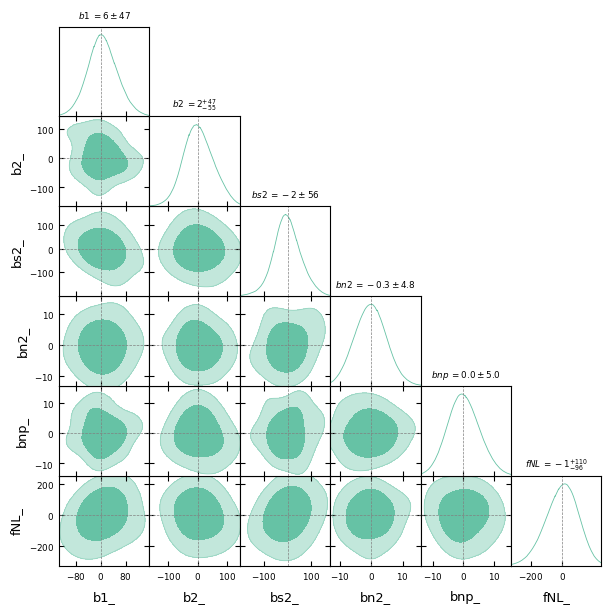

In [66]:
from getdist import plots
from montecosmo.plot import SetDark2
gdsamp = theta[['bias_']].to_getdist()
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)